#Functions

In [1]:
def undersampling(dataframe):
  no_risk = len(dataframe[dataframe['risk_flag'] == 1])
  no_risk_samples = dataframe[dataframe["risk_flag"] == 0].index
  random_no_risk_samples = np.random.choice(no_risk_samples, no_risk, replace=False)
  risk_samples = dataframe[dataframe['risk_flag'] == 1].index
  under_sampled = np.concatenate([risk_samples, random_no_risk_samples])
  dataframe = riskDF.loc[under_sampled]
  dataframe = dataframe.sample(frac = 1)
  return dataframe

In [2]:
def preprocess(dataframe):
  dataframe = dataframe.drop('Id', axis=1)
  dataframe = dataframe.drop('city', axis=1)
  dataframe = dataframe.drop('state', axis=1)

  lbe = LabelEncoder()
  dataframe["married"] = lbe.fit_transform(dataframe["married"])
  dataframe["car_ownership"] = lbe.fit_transform(dataframe["car_ownership"])

  dataframe = pd.get_dummies(dataframe, columns = ["house_ownership"], prefix = ["house_ownership"])
  dataframe = pd.get_dummies(dataframe, columns = ["profession"], prefix = ["profession"])

  cols_to_norm = ['income','age', 'experience', 'current_job_years', 'current_house_years']
  dataframe[cols_to_norm] = dataframe[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
  return dataframe

In [3]:
def predictionCV(dataframe, target, model, param_grid):
  
  print(str(model))
  X_train, X_test, y_train, y_test = train_test_split(dataframe, target, test_size=0.10)

  grid = GridSearchCV(model, param_grid, cv = 10, scoring = 'accuracy', verbose=3)
  start = time.time()
  grid.fit(X_train, y_train)
  stop = time.time()
  
  print("Train-Validation")
  print("best parameters")
  print(grid.best_params_)
  print("best accuracy score")
  print(grid.best_score_)
  print("best estimator")
  print(grid.best_estimator_)
  print(f"Training time: {stop - start}s")

  print("Test")
  y_true, y_pred = y_test, grid.predict(X_test)
  print("accuracy of the test")
  print(accuracy_score(y_test, y_pred))
  print("report")
  print(classification_report(y_true, y_pred))
  
  cm= confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(10,10))
  plt.title('Confusion matrix of the classifier')
  sns.heatmap(cm,annot=True, fmt=".1f", cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))
  plt.xlabel('Predicted')
  plt.xticks(rotation=45)
  plt.ylabel('True')
  plt.ioff()
  plt.show()

  return accuracy_score(y_test, y_pred)
    

In [4]:
def prediction(dataframe, target, model):
  X_train, X_test, y_train, y_test = train_test_split(dataframe, target, test_size=0.10)
  start = time.time()
  model.fit(X_train, y_train)
  stop = time.time()
  training_time = stop - start
  y_pred = model.predict(X_test)
  return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), training_time

#Main



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import time


In [6]:
np.random.seed(0)

Read Csv

In [7]:
riskDF = pd.read_csv("Training Data.csv") #dataset

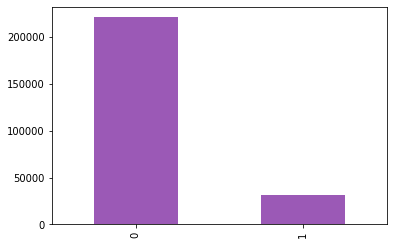

In [8]:
risk_flag = riskDF["risk_flag"]
risk_flag.value_counts().plot(kind="bar", color="#9b59b6")

Outlier Detection

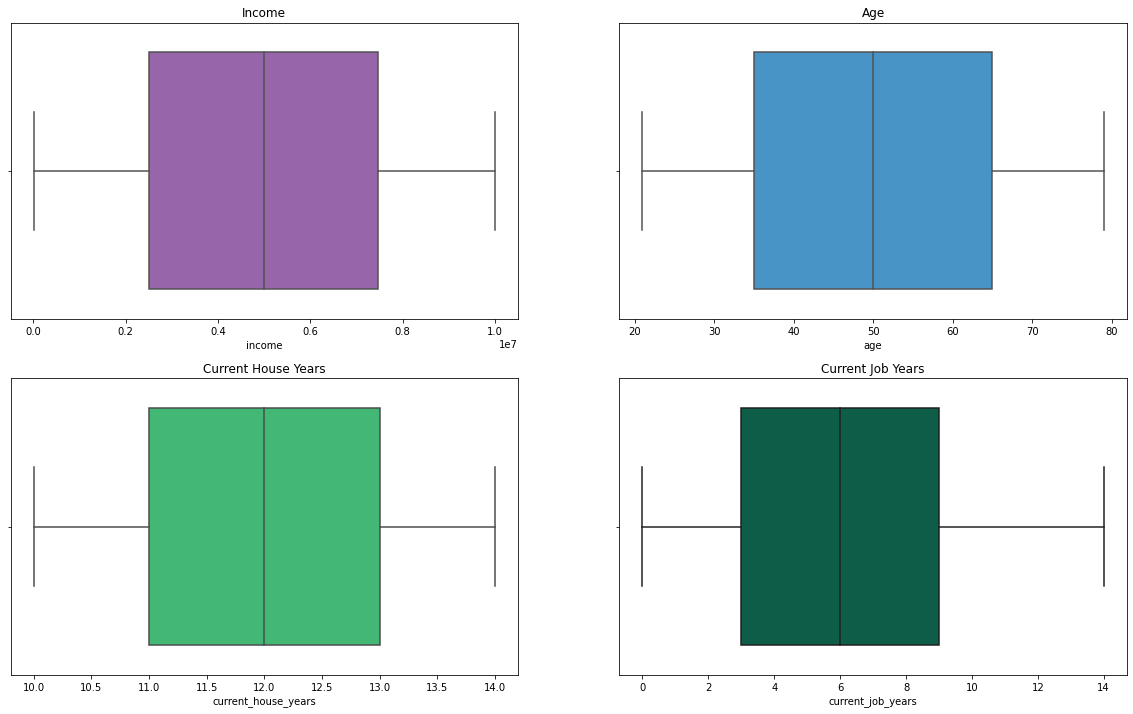

In [9]:
fig, axs = plt.subplots(2, 2,figsize=(20,12),)
sns.boxplot(x=riskDF["income"] ,ax=axs[0,0], color="#9b59b6")
axs[0, 0].set_title('Income')
sns.boxplot(x = riskDF["age"], ax=axs[0,1], color="#3498db")
axs[0, 1].set_title('Age')
sns.boxplot(x = riskDF["current_house_years"], ax=axs[1,0], color="#2ecc71")
axs[1, 0].set_title('Current House Years')
sns.boxplot(x =riskDF["current_job_years"], ax=axs[1,1], color="#006a4e")
axs[1, 1].set_title('Current Job Years');

Heatmap

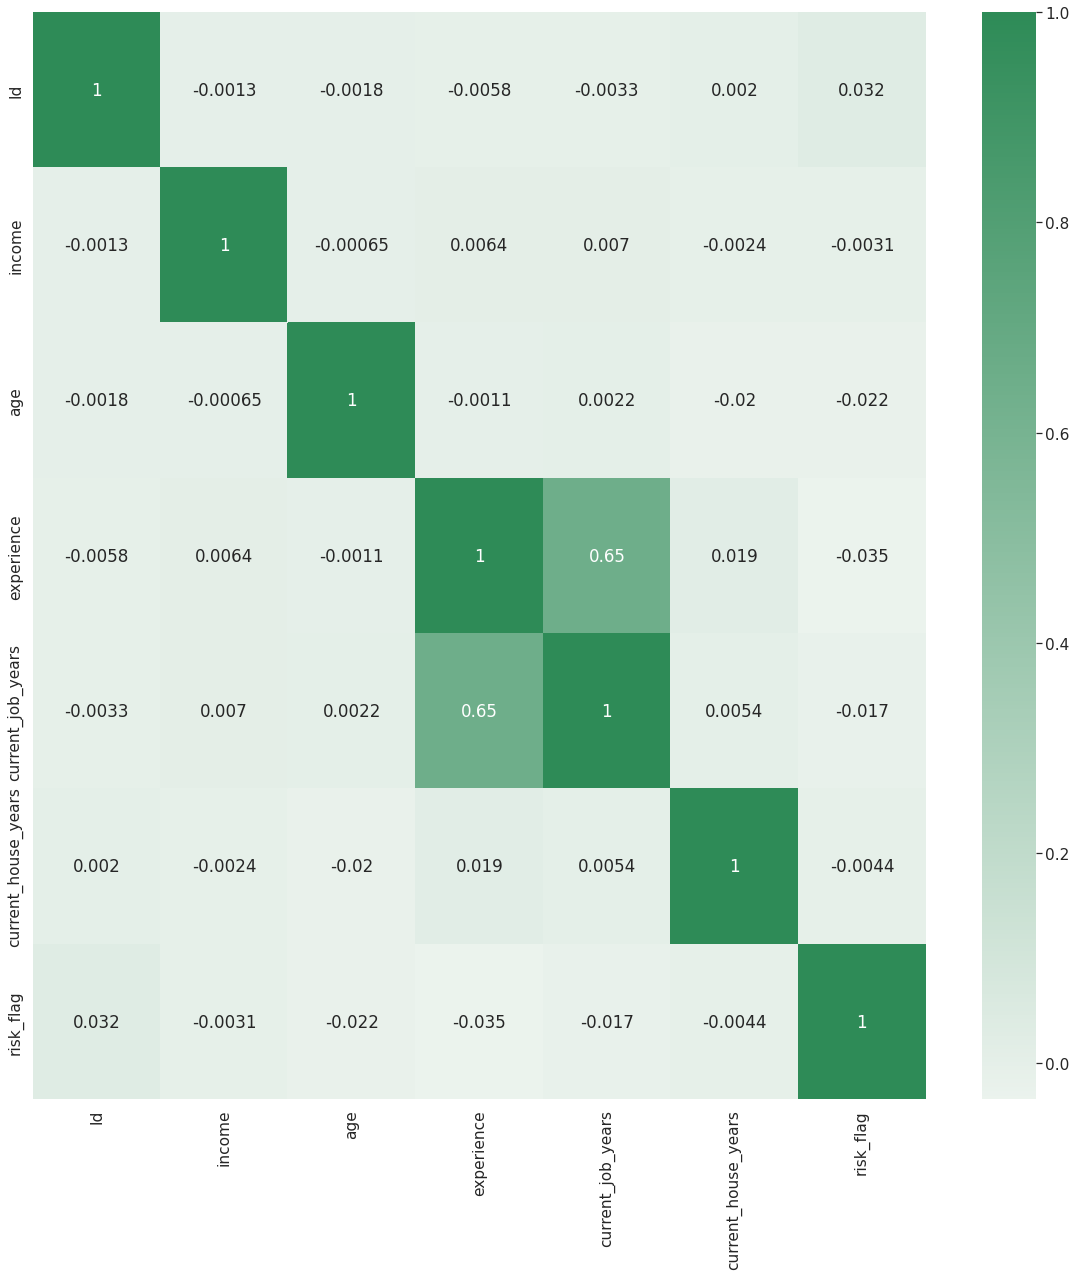

In [10]:
X = riskDF
y = risk_flag
#get correlations of each features in dataset
corrmat = riskDF.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
sns.light_palette("seagreen", as_cmap=True)
sns.set(font_scale=1.4)
g=sns.heatmap(riskDF[top_corr_features].corr(),annot=True,cmap=sns.light_palette("seagreen", as_cmap=True))

Create Undersampled Dataset

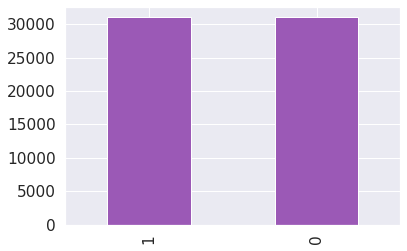

In [11]:
undersampled_riskDF = undersampling(riskDF) 
undersampled_risk_flag = undersampled_riskDF["risk_flag"]
undersampled_risk_flag.value_counts().plot(kind="bar", color="#9b59b6")

Preprocessed Datasets

In [12]:
riskDF = preprocess(riskDF) 
riskDF = riskDF.drop('risk_flag', axis=1)

undersampled_riskDF = preprocess(undersampled_riskDF)
undersampled_riskDF = undersampled_riskDF.drop('risk_flag', axis=1)

Create Models and Paramters

In [13]:
knn_neighbors = [1, 3, 5, 7]
tree_type = ['gini','entropy']
tree_depth = [20,30,40,50,70,90,120,150]

In [14]:
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
nb = GaussianNB()

In [15]:
param_grid_knn = dict(n_neighbors = knn_neighbors)
param_grid_nb = {} 
param_grid_tree = {'criterion':tree_type,'max_depth':tree_depth}

Cross-validation, n = 10, %90 - %10

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=1, score=0.825, total=   2.7s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.829, total=   2.6s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.834, total=   4.1s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.832, total=   2.6s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.822, total=   2.8s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.838, total=   2.6s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.837, total=   2.6s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.824, total=   2.8s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.825, total=   2.8s
[CV] n_neighbors=1 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.5min finished


Train-Validation
best parameters
{'n_neighbors': 3}
best accuracy score
0.8397619850681737
best estimator
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Training time: 148.39246010780334s
Test
accuracy of the test
0.8456451612903226
report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3088
           1       0.86      0.83      0.84      3112

    accuracy                           0.85      6200
   macro avg       0.85      0.85      0.85      6200
weighted avg       0.85      0.85      0.85      6200



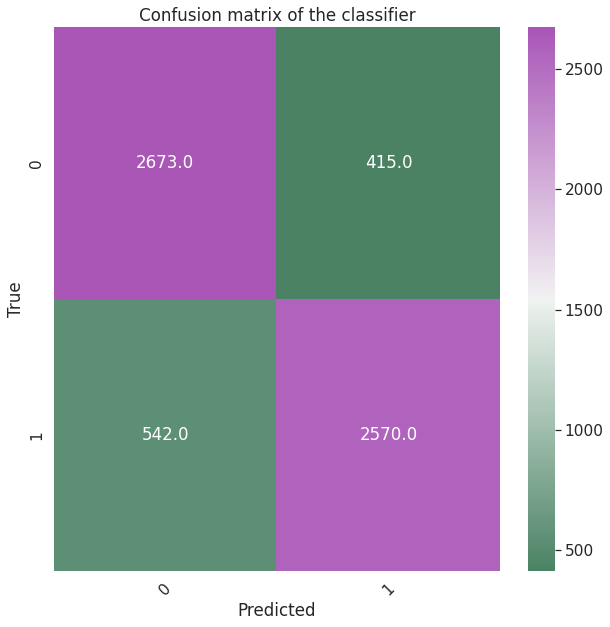

In [16]:
accuracy_knn_undersampled = predictionCV(undersampled_riskDF, undersampled_risk_flag, knn, param_grid_knn)

GaussianNB(priors=None, var_smoothing=1e-09)
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] .................................... , score=0.525, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.536, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... , score=0.532, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.544, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.535, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.521, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.533, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.536, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.521, total=   0.1s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


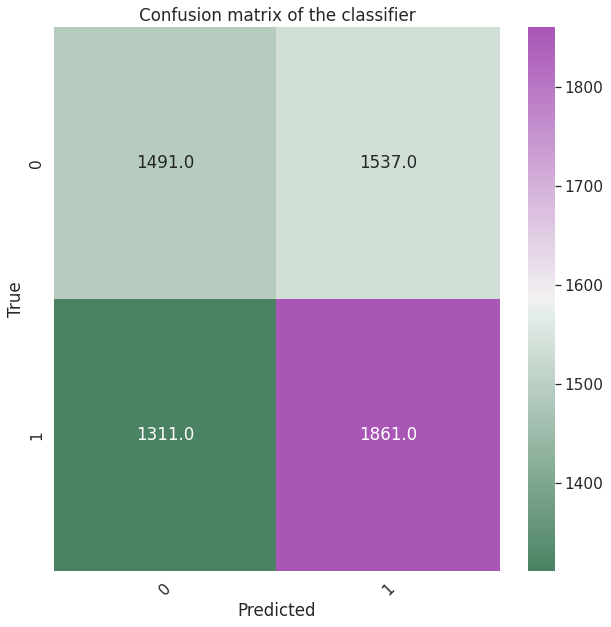

In [17]:
accuracy_nb_undersampled = predictionCV(undersampled_riskDF, undersampled_risk_flag, nb, param_grid_nb)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=20 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ criterion=gini, max_depth=20, score=0.752, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ........ criterion=gini, max_depth=20, score=0.734, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] ........ criterion=gini, max_depth=20, score=0.746, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.701, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.722, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.745, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.753, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.728, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.754, total=   0.4s
[CV] criterion=gini, max_depth=20 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.5min finished


Train-Validation
best parameters
{'criterion': 'gini', 'max_depth': 150}
best accuracy score
0.8617005976713752
best estimator
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=150, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Training time: 88.24227905273438s
Test
accuracy of the test
0.8674193548387097
report
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3071
           1       0.87      0.87      0.87      3129

    accuracy                           0.87      6200
   macro avg       0.87      0.87      0.87      6200
weighted avg       0.87      0.87      0.87      6200



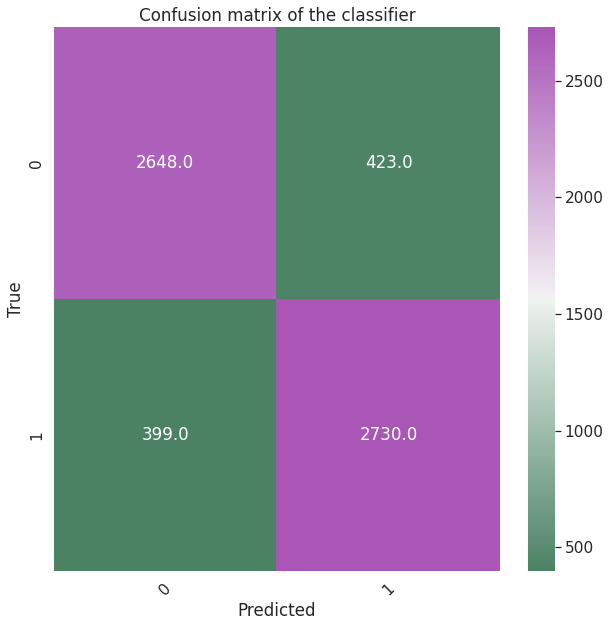

In [18]:
accuracy_tree_undersampled = predictionCV(undersampled_riskDF, undersampled_risk_flag, tree, param_grid_tree)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=1, score=0.878, total=  31.4s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.4s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.875, total=  32.7s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.872, total=  32.7s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.877, total=  32.4s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.877, total=  31.2s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.877, total=  31.0s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.873, total=  30.7s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.874, total=  30.9s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.875, total=  52.8s
[CV] n_neighbors=1 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 26.4min finished


Train-Validation
best parameters
{'n_neighbors': 7}
best accuracy score
0.8900925925925925
best estimator
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')
Training time: 1597.2328205108643s
Test
accuracy of the test
0.8936111111111111
report
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     22158
           1       0.56      0.52      0.54      3042

    accuracy                           0.89     25200
   macro avg       0.75      0.73      0.74     25200
weighted avg       0.89      0.89      0.89     25200



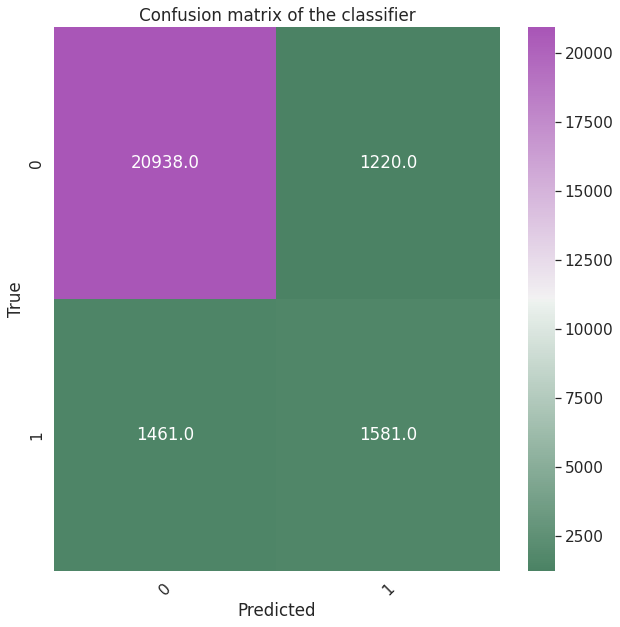

In [19]:
accuracy_knn = predictionCV(riskDF, risk_flag, knn, param_grid_knn)

GaussianNB(priors=None, var_smoothing=1e-09)
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.662, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... , score=0.644, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .................................... , score=0.653, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.651, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.661, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.660, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.663, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.676, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.671, total=   0.3s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished


Train-Validation
best parameters
{}
best accuracy score
0.6598412698412698
best estimator
GaussianNB(priors=None, var_smoothing=1e-09)
Training time: 3.4017820358276367s
Test
accuracy of the test
0.6618253968253969
report
              precision    recall  f1-score   support

           0       0.89      0.70      0.79     22118
           1       0.14      0.36      0.20      3082

    accuracy                           0.66     25200
   macro avg       0.52      0.53      0.50     25200
weighted avg       0.80      0.66      0.71     25200



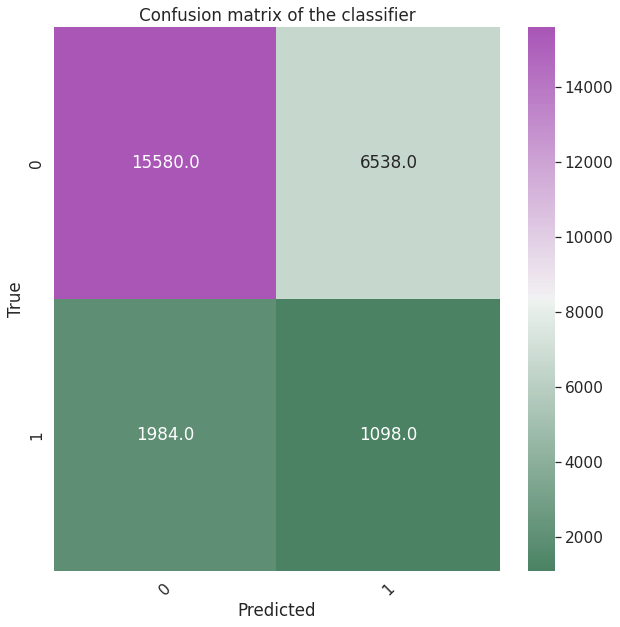

In [20]:
accuracy_nb = predictionCV(riskDF, risk_flag, nb, param_grid_nb)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=20 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ criterion=gini, max_depth=20, score=0.888, total=   2.0s
[CV] criterion=gini, max_depth=20 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ........ criterion=gini, max_depth=20, score=0.888, total=   1.9s
[CV] criterion=gini, max_depth=20 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] ........ criterion=gini, max_depth=20, score=0.890, total=   1.9s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.890, total=   1.9s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.886, total=   1.9s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.887, total=   1.9s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.888, total=   2.0s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.888, total=   1.9s
[CV] criterion=gini, max_depth=20 ....................................
[CV] ........ criterion=gini, max_depth=20, score=0.888, total=   2.0s
[CV] criterion=gini, max_depth=20 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  7.3min finished


Train-Validation
best parameters
{'criterion': 'gini', 'max_depth': 20}
best accuracy score
0.8880996472663141
best estimator
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Training time: 437.5758626461029s
Test
accuracy of the test
0.8886111111111111
report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     22119
           1       0.58      0.31      0.41      3081

    accuracy                           0.89     25200
   macro avg       0.75      0.64      0.67     25200
weighted avg       0.87      0.89      0.87     25200



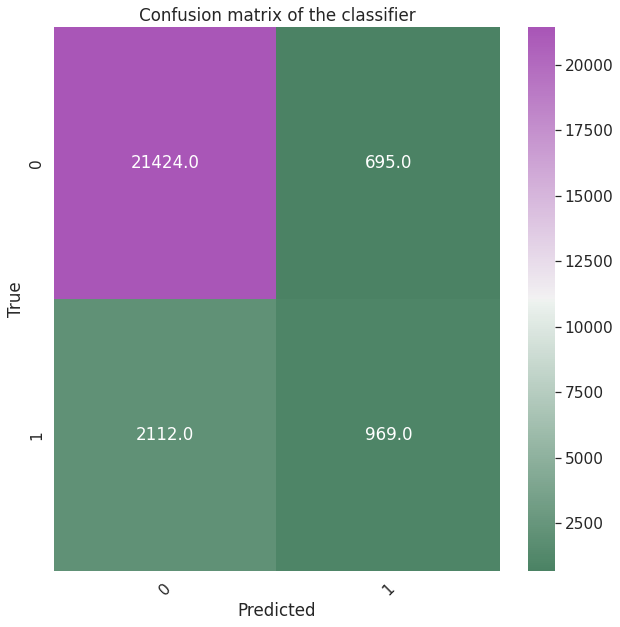

In [21]:
accuracy_tree = predictionCV(riskDF, risk_flag, tree, param_grid_tree)

In [22]:
names = ["KNN With Undersampled Dataset", "KNN", "Naive Bayes With Undersampled Dataset", "Naive Bayes", "Decision Tree With Undersampled Dataset", "Decision Tree"]
accuracies = [accuracy_knn_undersampled, accuracy_knn, accuracy_nb_undersampled, accuracy_nb, accuracy_tree_undersampled, accuracy_tree]
print(accuracies)

[0.8456451612903226, 0.8936111111111111, 0.5406451612903226, 0.6618253968253969, 0.8674193548387097, 0.8886111111111111]


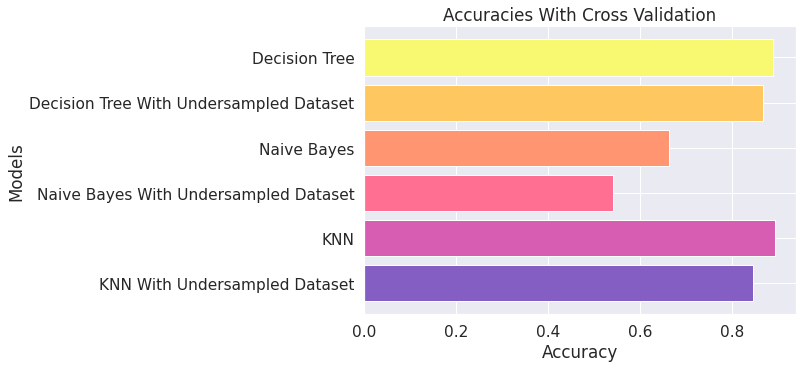

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(names,accuracies, color=["#845EC2", "#D65DB1", "#FF6F91", "#FF9671", "#FFC75F", "#F9F871"])
plt.title("Accuracies With Cross Validation")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.show();

Train - Test %90 - %10

In [24]:
knn_accuracies_undersampled = []
knn_classification_reports_undersampled = []
knn_training_time_undersampled = []
knn_accuracies = []
knn_classification_reports = []
knn_training_time = []

for neighbor in knn_neighbors:
  knn = KNeighborsClassifier(n_neighbors=neighbor)
  accuracy, classification, training_time = prediction(undersampled_riskDF, undersampled_risk_flag, knn)
  knn_accuracies_undersampled.append(accuracy)
  knn_classification_reports_undersampled.append(classification)
  knn_training_time_undersampled.append(training_time)
  accuracy, classification, training_time = prediction(riskDF, risk_flag, knn)
  knn_accuracies.append(accuracy)
  knn_classification_reports.append(classification)
  knn_training_time.append(training_time)

knn_best_accuracy_undersampled = max(knn_accuracies_undersampled)
index_undersampled = knn_accuracies_undersampled.index(knn_best_accuracy_undersampled)
print("best acc", knn_best_accuracy_undersampled)
print(knn_classification_reports_undersampled[index_undersampled])
print("best neighbor", knn_neighbors[index_undersampled])
print("training time", knn_training_time_undersampled[index_undersampled])

knn_best_accuracy = max(knn_accuracies)
index = knn_accuracies.index(knn_best_accuracy)
print("best acc:", knn_best_accuracy)
print(knn_classification_reports[index])
print("best neighbor:", knn_neighbors[index])
print("training time", knn_training_time[index])

best acc 0.8454838709677419
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3076
           1       0.86      0.82      0.84      3124

    accuracy                           0.85      6200
   macro avg       0.85      0.85      0.85      6200
weighted avg       0.85      0.85      0.85      6200

best neighbor 3
training time 0.8925662040710449
best acc: 0.8913492063492063
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     22146
           1       0.56      0.51      0.53      3054

    accuracy                           0.89     25200
   macro avg       0.74      0.73      0.74     25200
weighted avg       0.89      0.89      0.89     25200

best neighbor: 7
training time 13.654209852218628


In [25]:
nb = GaussianNB()

nb_best_accuracy_undersampled, nb_best_classification_undersampled, nb_best_training_time_undersampled = prediction(undersampled_riskDF, undersampled_risk_flag, nb)
nb_best_accuracy, nb_best_classification, nb_best_training_time = prediction(riskDF, risk_flag, nb)
print(nb_best_accuracy_undersampled)
print(nb_best_classification_undersampled)
print("training time", nb_best_training_time_undersampled)
print()
print(nb_best_accuracy)
print(nb_best_classification)
print("training time", nb_best_training_time)

0.5298387096774193
              precision    recall  f1-score   support

           0       0.53      0.50      0.52      3095
           1       0.53      0.56      0.54      3105

    accuracy                           0.53      6200
   macro avg       0.53      0.53      0.53      6200
weighted avg       0.53      0.53      0.53      6200

training time 0.059067726135253906

0.6629365079365079
              precision    recall  f1-score   support

           0       0.89      0.70      0.79     22150
           1       0.14      0.36      0.20      3050

    accuracy                           0.66     25200
   macro avg       0.52      0.53      0.50     25200
weighted avg       0.80      0.66      0.72     25200

training time 0.27026939392089844


In [26]:
tree_accuracies_undersampled = []
tree_classification_reports_undersampled = []
tree_training_time_undersampled = []
tree_accuracies = []
tree_classification_reports = []
tree_training_time = []
tree_criteria = []

for criterion in tree_type:
  for depth in tree_depth:
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
    tree_criteria.append([criterion, depth])
    accuracy, classification, training_time = prediction(undersampled_riskDF, undersampled_risk_flag, tree)
    tree_accuracies_undersampled.append(accuracy)
    tree_classification_reports_undersampled.append(classification)
    tree_training_time_undersampled.append(training_time)
    accuracy, classification, training_time = prediction(riskDF, risk_flag, tree)
    tree_accuracies.append(accuracy)
    tree_classification_reports.append(classification)
    tree_training_time.append(training_time)

tree_best_accuracy_undersampled = max(tree_accuracies_undersampled)
index_undersampled = tree_accuracies_undersampled.index(tree_best_accuracy_undersampled)
print("best acc", tree_best_accuracy_undersampled)
print(tree_classification_reports_undersampled[index_undersampled])
print(tree_criteria[index_undersampled])
print("training time", tree_training_time_undersampled[index_undersampled])

tree_best_accuracy = max(tree_accuracies)
index = tree_accuracies.index(tree_best_accuracy)
print("best acc:", tree_best_accuracy)
print(tree_classification_reports[index])
print(tree_criteria[index])
print("training time", tree_training_time[index])

best acc 0.867741935483871
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3163
           1       0.86      0.88      0.87      3037

    accuracy                           0.87      6200
   macro avg       0.87      0.87      0.87      6200
weighted avg       0.87      0.87      0.87      6200

['entropy', 70]
training time 0.7056882381439209
best acc: 0.8877777777777778
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     22107
           1       0.57      0.35      0.43      3093

    accuracy                           0.89     25200
   macro avg       0.74      0.65      0.68     25200
weighted avg       0.87      0.89      0.88     25200

['gini', 20]
training time 2.2131261825561523


In [27]:
names = ["KNN With Undersampled Dataset", "KNN", "Naive Bayes With Undersampled Dataset", "Naive Bayes", "Decision Tree With Undersampled Dataset", "Decision Tree"]
accuracies = [knn_best_accuracy_undersampled, knn_best_accuracy, nb_best_accuracy_undersampled, nb_best_accuracy, tree_best_accuracy_undersampled, tree_best_accuracy]

In [28]:
print(accuracies)

[0.8454838709677419, 0.8913492063492063, 0.5298387096774193, 0.6629365079365079, 0.867741935483871, 0.8877777777777778]


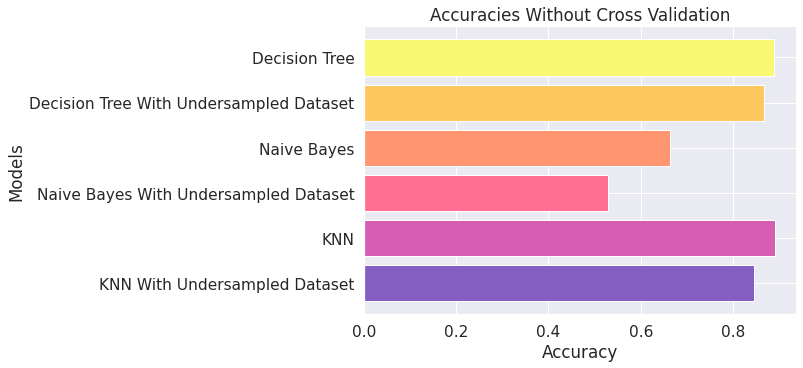

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(names,accuracies, color=["#845EC2", "#D65DB1", "#FF6F91", "#FF9671", "#FFC75F", "#F9F871"])
plt.title("Accuracies Without Cross Validation")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.show();